In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.wcs.utils import proj_plane_pixel_scales as pixscales
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
# conda install photutils -c astropy
from photutils.aperture import aperture_photometry
from photutils.aperture import SkyCircularAperture
from matplotlib.ticker import MultipleLocator


In [2]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel


## Calibration factor interpolation verification 

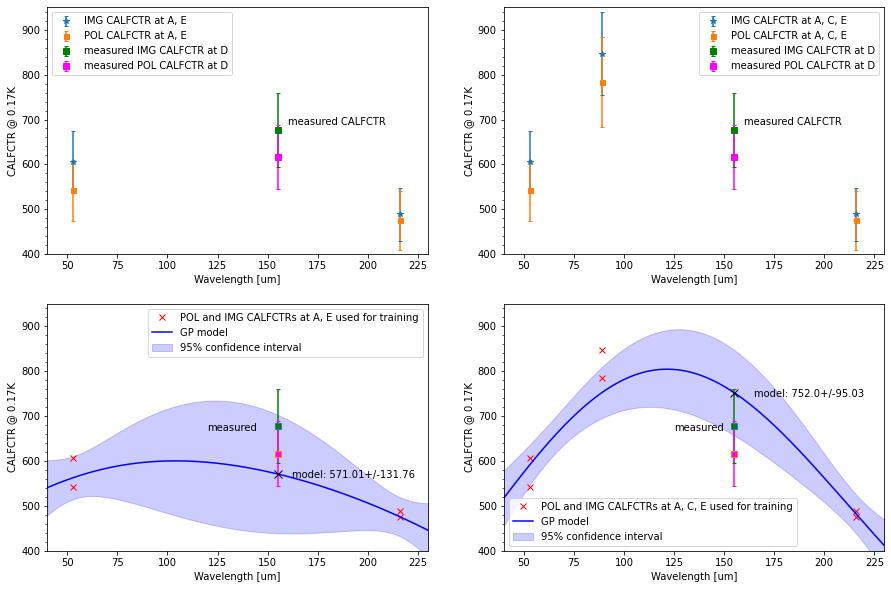

In [4]:
#at nominal temp:
    
fctr_A, fctr_err_A = 605.919, 68.61652
fctr_E, fctr_err_E = 488.6206, 59.4351
fctr_D, fctr_err_D = 677.4844, 82.21562
fctr_C, fctr_err_C = 846.7939, 92.28771

#polarization factors [these are the average values in the appendix 6.1]
pfctr_A, pfctr_err_A = 542.0972, 68.41572
pfctr_E, pfctr_err_E = 475.4609, 65.51294
pfctr_D, pfctr_err_D = 616.466, 71.72359
pfctr_C, pfctr_err_C = 784.2601, 99.81317

wl_A = 53
wl_C = 89
wl_D = 155
wl_E = 216

# A_lo, A_hi= 
# C_lo, C_hi=
# D_lo, D_hi=
# E_lo, E_hi=

fpath = '/Users/seftekh1/Desktop/highTemp/'

vmin = 400
vmax = 950

hmin = 40
hmax = 230

mly = MultipleLocator(20)
mlx = MultipleLocator(50)


a, b = np.asarray([fctr_A, fctr_E]),np.asarray([wl_A, wl_E])


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.errorbar(b,a,[fctr_err_A,fctr_err_E],marker='*',ls='',label='IMG CALFCTR at A, E', capsize=2)
ax1.errorbar(b,[pfctr_A,pfctr_E],[pfctr_err_A,pfctr_err_E],marker='s',ls='',
             markersize=5,label='POL CALFCTR at A, E', capsize=2)
ax1.errorbar(wl_D,fctr_D,fctr_err_D,marker='s',ls='',label='measured IMG CALFCTR at D',color='g', capsize=2)
ax1.errorbar(wl_D,pfctr_D,pfctr_err_D,marker='s',ls='',label='measured POL CALFCTR at D',color='magenta', capsize=2)
ax1.legend(loc='upper left')

ax1.annotate('measured CALFCTR',xy=(wl_D,fctr_D), xytext=(wl_D+5,fctr_D+10))

ax1.set_ylim(vmin,vmax)
ax1.set_ylabel('CALFCTR @ 0.17K')
ax1.set_xlabel('Wavelength [um]')
ax1.yaxis.set_minor_locator(mly)
ax1.xaxis.set_minor_locator(mlx)
ax1.set_xlim(hmin,hmax)

######################################

a, b = np.asarray([fctr_A, fctr_C, fctr_E]),np.asarray([wl_A, wl_C, wl_E])
ax2.errorbar(b,a,[fctr_err_A,fctr_err_C,fctr_err_E],marker='*',ls='',label='IMG CALFCTR at A, C, E', capsize=2)
ax2.errorbar(b,[pfctr_A,pfctr_C,pfctr_E],[pfctr_err_A, pfctr_err_C, pfctr_err_E],
             marker='s',ls='',markersize=5,label='POL CALFCTR at A, C, E', capsize=2)
ax2.errorbar(wl_D,fctr_D,fctr_err_D,marker='s',ls='',label='measured IMG CALFCTR at D',color='g', capsize=2)
ax2.errorbar(wl_D,pfctr_D,pfctr_err_D,marker='s',ls='',label='measured POL CALFCTR at D',color='magenta', capsize=2)
ax2.legend(loc='upper right')

ax2.annotate('measured CALFCTR',xy=(wl_D,fctr_D), xytext=(wl_D+5,fctr_D+10))

ax2.set_ylim(vmin,vmax)
ax2.set_ylabel('CALFCTR @ 0.17K')
ax2.set_xlabel('Wavelength [um]')
ax2.yaxis.set_minor_locator(mly)
ax2.xaxis.set_minor_locator(mlx)
ax2.set_xlim(hmin,hmax)

######################################
X_train = np.asarray([wl_A, wl_E, wl_A, wl_E]).reshape(-1, 1)
Y_train = np.array([fctr_A, fctr_E, pfctr_A, pfctr_E]).reshape(-1, 1)
y_err = np.array([fctr_err_A, fctr_err_E, pfctr_err_A, pfctr_err_E])

X = np.linspace(40,250, 1000).reshape(-1, 1)

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,
                               alpha=y_err**2).fit(X_train, Y_train)
gpc.score(Y_train, Y_train) 

Y, sigma = gpc.predict(X, return_std=True)

ax3.plot(X_train, Y_train, 'x', color='r',label='POL and IMG CALFCTRs at A, E used for training')


X0 = X.ravel()
Y0 = Y.ravel()
sigma0 = sigma.ravel()
ax3.plot(X0,Y0, color='blue',label='GP model')
ax3.fill_between(X0,Y0+1.*sigma0, Y0-1.*sigma0, alpha=.2, color='blue', label='95% confidence interval')

# adding the check point
ax3.errorbar([wl_D], [fctr_D], yerr=[fctr_err_D], marker='s', mfc='g', ecolor='g', capsize=2)
ax3.errorbar([wl_D], [pfctr_D], yerr=[pfctr_err_D], marker='s', mfc='magenta', ecolor='magenta', capsize=2)

ax3.set_ylim(vmin,vmax)
ax3.set_ylabel('CALFCTR @ 0.17K')
ax3.set_xlabel('Wavelength [um]')
ax3.legend(loc='upper right')
ax3.annotate('measured',xy=(wl_D,fctr_D), xytext=(wl_D-35,fctr_D-10))
ax3.yaxis.set_minor_locator(mly)
ax3.xaxis.set_minor_locator(mlx)
ax3.set_xlim(hmin,hmax)
#  test model prediction for CALFCTR unknown band/wl and 1-sigma uncertainty
x = [155]
xt = np.asarray(x).reshape(-1,1)
yt, sigma = gpc.predict(xt, return_std=True)
yt, sigma
ax3.annotate('model: '+str(np.round(yt[0],2)[0])+'+/-'+str(np.round(sigma[0],2)),xy=(x[0],yt[0]), xytext=(x[0]+7,yt[0]-10))

ax3.plot(x, yt, marker="x", color='k', markersize=8)


######################################
X_train = np.asarray([wl_A, wl_E, wl_A, wl_E, wl_C, wl_C]).reshape(-1, 1)
Y_train = np.array([fctr_A, fctr_E, pfctr_A, pfctr_E, fctr_C, pfctr_C]).reshape(-1, 1)
y_err = np.array([fctr_err_A, fctr_err_E, pfctr_err_A, pfctr_err_E, fctr_err_C, pfctr_err_C ])

X = np.linspace(40,250, 1000).reshape(-1, 1)

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20,
                               alpha=y_err**2).fit(X_train, Y_train)
gpc.score(Y_train, Y_train) 

Y, sigma = gpc.predict(X, return_std=True)

ax4.plot(X_train, Y_train, 'x', color='r',label='POL and IMG CALFCTRs at A, C, E used for training')

X0 = X.ravel()
Y0 = Y.ravel()
sigma0 = sigma.ravel()
ax4.plot(X0,Y0, color='blue',label='GP model')
ax4.fill_between(X0,Y0+1.*sigma0, Y0-1.*sigma0, alpha=.2, color='blue', label='95% confidence interval')

# adding the check point
ax4.errorbar([wl_D], [fctr_D], yerr=[fctr_err_D], marker='s', mfc='g', ecolor='g', capsize=2)
ax4.errorbar([wl_D], [pfctr_D], yerr=[pfctr_err_D], marker='s', mfc='magenta', ecolor='magenta', capsize=2)
ax4.set_ylim(vmin,vmax)
ax4.set_xlim(hmin,hmax)

ax4.set_ylabel('CALFCTR @ 0.17K')
ax4.set_xlabel('Wavelength [um]')
ax4.legend(loc='lower left')
ax4.annotate('measured',xy=(wl_D,fctr_D), xytext=(wl_D-30,fctr_D-10))
ax4.yaxis.set_minor_locator(mly)
ax4.xaxis.set_minor_locator(mlx)


#  test model prediction for CALFCTR unknown band/wl and 1-sigma uncertainty
x = [155]
xt = np.asarray(x).reshape(-1,1)
yt, sigma = gpc.predict(xt, return_std=True)
yt, sigma
ax4.annotate('model: '+str(np.round(yt[0],2)[0])+'+/-'+str(np.round(sigma[0],2)),xy=(x[0],yt[0]), xytext=(x[0]+10,yt[0]-10))

ax4.plot(x, yt, marker="x", color='k', markersize=8)

########################################